# Melhorando a performance de modelos com validação cruzada e bootstrapping

A validação cruzada consiste em uma técnica mais robusta do que a simples estratificação dos dados em treino e teste. Também conhecida como k-fold cross-validation, **divide de forma aleatória os dados de um conjunto de treinamento em subconjuntos distintos (os chamados folds), então treina e avalia o modelo em cada subconjunto de dados obtendo resultados diferentes de acordo com a iteração de K escolhida**.
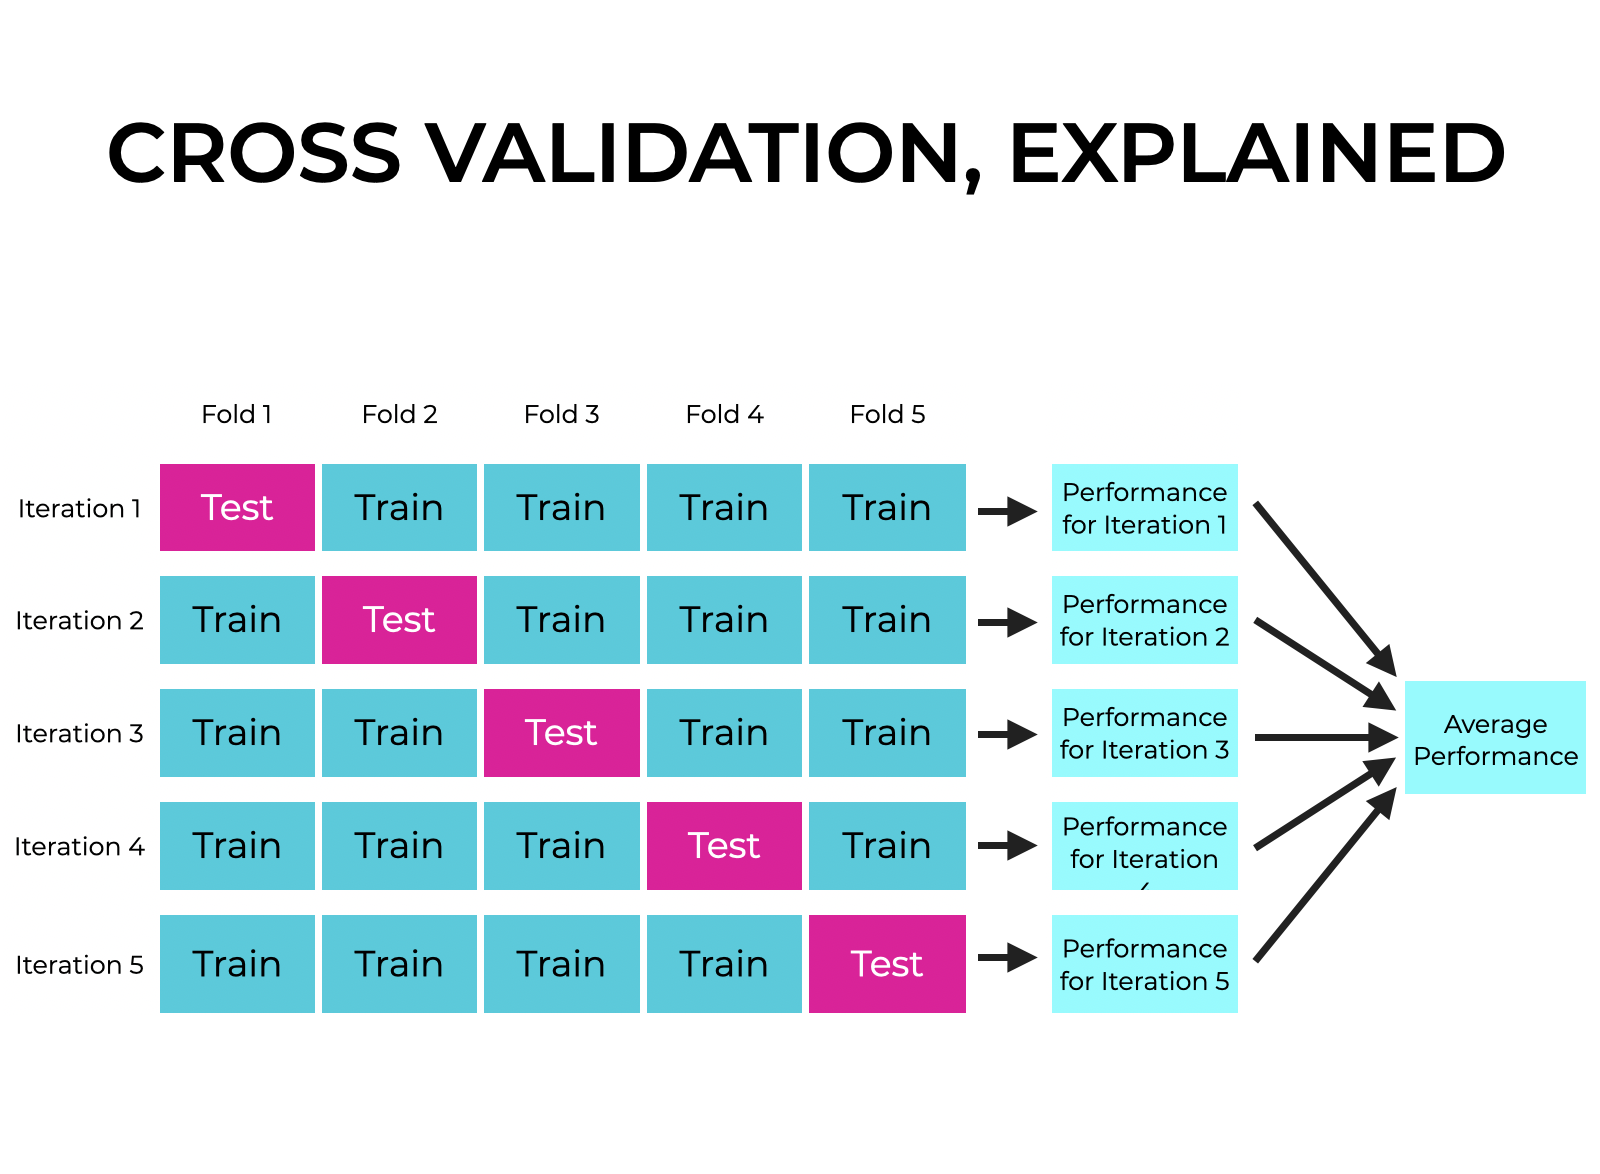


Para testar essa técnica robusta, vamos criar um modelo preditivo para prever o status de rotatividade do banco, prevendo se a pessoa saí ou não. Um clássico modelo de classificação! 🏦.


In [ ]:
import pandas as pd
pd.set_option('display.max_columns', None)
df = pd.read_csv('Churn_Modelling.csv', sep=';')
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [ ]:
df.shape

(9865, 14)

# Pipeline de tratamento dos dados categóricos e limpeza da base

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

one_hot_cols = ['Geography', 'Gender']
drop_cols = ['RowNumber', 'CustomerId', 'Surname'] + one_hot_cols

# Criar a pipeline
pipeline = Pipeline([
    ('preprocessor', ColumnTransformer(
        transformers=[
            ('onehot', OneHotEncoder(), one_hot_cols)
        ],
        remainder='drop'
    ))
])

# Aplicar a pipeline ao DataFrame
transformed_df = pipeline.fit_transform(df)

# Converter o resultado de volta para um DataFrame
transformed_df = pd.DataFrame(transformed_df)

# Adicionar os nomes das colunas de volta
one_hot_encoded_cols = pipeline.named_steps['preprocessor'] \
                              .named_transformers_['onehot'] \
                              .get_feature_names_out(one_hot_cols)

transformed_df.columns = one_hot_encoded_cols

# Concatenar com as colunas restantes do DataFrame original
df = pd.concat([df.drop(columns=drop_cols), transformed_df], axis=1)
df.head()


,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,1.0,0.0,0.0,1.0,0.0
1,608,41,1,83807.86,1,0,1,112542.58,0,0.0,0.0,1.0,1.0,0.0
2,502,42,8,159660.80,3,1,0,113931.57,1,1.0,0.0,0.0,1.0,0.0
3,699,39,1,0.00,2,0,0,93826.63,0,1.0,0.0,0.0,1.0,0.0
4,850,43,2,125510.82,1,1,1,79084.10,0,0.0,0.0,1.0,1.0,0.0


In [ ]:
df.shape

(9865, 14)

# Separando os dados em treino e teste

In [ ]:
from sklearn.model_selection import train_test_split

X = df.drop(columns='Exited')
y = df['Exited']

# Equilibrando a target

In [ ]:
df['Exited'].value_counts(normalize=True)*100

Exited
0    80.719716
1    19.280284
Name: proportion, dtype: float64

In [ ]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

In [ ]:
y_resampled.value_counts(normalize=True)*100

Exited
1    50.0
0    50.0
Name: proportion, dtype: float64

In [ ]:
# Dividir os dados em treino e teste # hold out
x_train, x_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.25, random_state=42)

# Normalizando os dados

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

pipeline = Pipeline([
    ('scaler', scaler)
])

pipeline.fit(x_train, y_train)

x_train_scaled = pipeline.fit_transform(x_train)
x_test_scaled = pipeline.fit_transform(x_test)

x_train_scaled = pd.DataFrame(x_train_scaled, columns=X.columns )
x_test_scaled = pd.DataFrame(x_test_scaled, columns=X.columns)

In [ ]:
x_train_scaled

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,0.456,0.310811,0.2,0.540181,0.000000,0.0,0.0,0.754160,0.000000,0.548577,0.451423,0.548577,0.451423
1,0.808,0.527027,0.2,0.403091,0.333333,1.0,1.0,0.354748,0.000000,1.000000,0.000000,0.000000,1.000000
2,0.252,0.256757,0.4,0.000000,0.000000,1.0,1.0,0.278848,1.000000,0.000000,0.000000,0.000000,1.000000
3,0.492,0.324324,0.7,0.000000,0.333333,1.0,1.0,0.607842,1.000000,0.000000,0.000000,0.000000,1.000000
4,0.750,0.297297,0.1,0.371205,0.000000,0.0,0.0,0.358975,0.000000,1.000000,0.000000,0.038049,0.961951
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11939,0.722,0.405405,0.5,0.460012,0.000000,0.0,0.0,0.956680,0.777296,0.222704,0.000000,0.222704,0.777296
11940,0.770,0.270270,0.1,0.000000,0.666667,0.0,0.0,0.461087,1.000000,0.000000,0.000000,1.000000,0.000000
11941,0.634,0.337838,0.8,0.758186,0.000000,1.0,0.0,0.487529,1.000000,0.000000,0.000000,0.000000,1.000000
11942,0.664,0.324324,0.5,0.430064,0.000000,0.0,0.0,0.470862,0.000000,1.000000,0.000000,0.589483,0.410517


# Testando o modelo com validação cruzada

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

modelo_RFC_cv = RandomForestClassifier(class_weight='balanced',
                                       n_estimators= 200,
                                       max_depth= 8,
                                       random_state=42)

scores = cross_val_score(modelo_RFC_cv, x_train_scaled, y_train, cv=10, scoring='accuracy')

print(scores)
print("Acurácia média com validação cruzada:", scores.mean())


[0.86861925 0.88451883 0.87615063 0.87112971 0.88274707 0.88693467
 0.89028476 0.88190955 0.85008375 0.87437186]
Acurácia média com validação cruzada: 0.8766750068333298


              precision    recall  f1-score   support

           0       0.85      0.91      0.88      2044
           1       0.89      0.84      0.86      1938

    accuracy                           0.87      3982
   macro avg       0.87      0.87      0.87      3982
weighted avg       0.87      0.87      0.87      3982



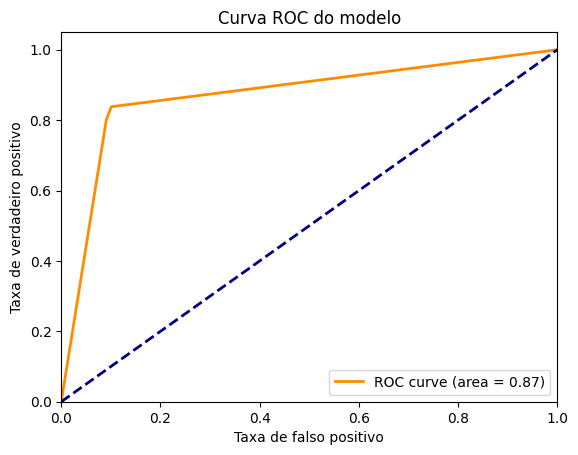

[[1850  194]
 [ 316 1622]]


In [ ]:
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

modelo_RFC_cv.fit(x_train_scaled, y_train)

y_pred = modelo_RFC_cv.predict(x_test_scaled)

print(classification_report(y_test, y_pred))

fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)


fpr_smooth = np.linspace(fpr[0], fpr[-1], 100)
tpr_smooth = np.interp(fpr_smooth, fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr_smooth, tpr_smooth, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de falso positivo')
plt.ylabel('Taxa de verdadeiro positivo')
plt.title('Curva ROC do modelo')
plt.legend(loc="lower right")
plt.show()

matriz = confusion_matrix(y_test, y_pred)
print(matriz)

# Testando com modelo de bootstrap

Essa  técnica é uma poderosa ferramenta utilizada para avaliar a performance e robustez de modelos de aprendizado de máquina.  Imagine que ao selecionar um modelo de machine learning para treinar o padrão nos dados, o bootstrap utiliza todo o conjunto de dados original para serem criadas diversas amostras menores, chamadas de amostras bootstrap (múltiplas amostras).  Quando a amostragem é realizada com substituição, ou seja, os pontos podem ser selecionados mais de uma única vez no processo, este método é chamado de bagging (abreviação de bootstrap aggregating).

In [ ]:
# Modificando o RandomForestClassifier para usar bootstrap
modelo_RFC_b = RandomForestClassifier(class_weight='balanced',
                                      n_estimators=200,
                                      max_depth=8,
                                      random_state=42,
                                      bootstrap=True)

# cross-validation
scores = cross_val_score(modelo_RFC_b, x_train_scaled, y_train, cv=10, scoring='accuracy')

print(scores)
print("Acurácia média com validação cruzada:", scores.mean())


[0.86861925 0.88451883 0.87615063 0.87112971 0.88274707 0.88693467
 0.89028476 0.88190955 0.85008375 0.87437186]
Acurácia média com validação cruzada: 0.8766750068333298


              precision    recall  f1-score   support

           0       0.85      0.91      0.88      2044
           1       0.89      0.84      0.86      1938

    accuracy                           0.87      3982
   macro avg       0.87      0.87      0.87      3982
weighted avg       0.87      0.87      0.87      3982



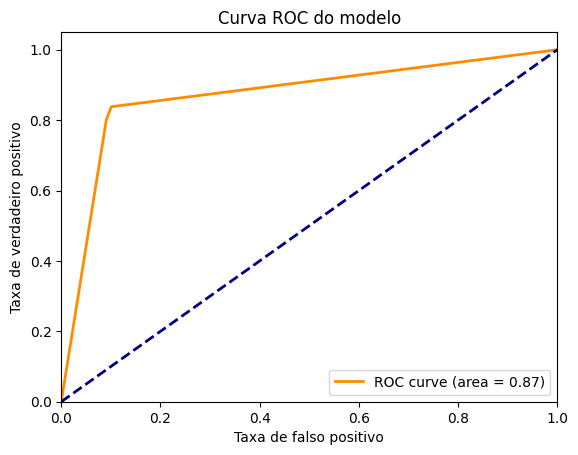

[[1850  194]
 [ 316 1622]]


In [ ]:
modelo_RFC_b.fit(x_train_scaled, y_train)

y_pred = modelo_RFC_b.predict(x_test_scaled)

print(classification_report(y_test, y_pred))

fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

fpr_smooth = np.linspace(fpr[0], fpr[-1], 100)
tpr_smooth = np.interp(fpr_smooth, fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr_smooth, tpr_smooth, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de falso positivo')
plt.ylabel('Taxa de verdadeiro positivo')
plt.title('Curva ROC do modelo')
plt.legend(loc="lower right")
plt.show()

matriz = confusion_matrix(y_test, y_pred)
print(matriz)